**Poisson equation in 1D with Dirichlet/Neumann boundary conditions**

Retyped by Theodoret Putra Agatho on 6 Aug. 2023

[Source](https://deepxde.readthedocs.io/en/latest/demos/pinn_forward/poisson.1d.neumanndirichlet.html)

In [ ]:
pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 11.8 MB/s eta 0:00:00


**Problem setup**

We will solve a Possion equation

\begin{align}
        \Delta u = 2, x \in [-1, 1].
    \end{align}

with the Neumann boundary conditions on the right boundary

\begin{align}
        \left. \frac{\partial u}{\partial x} \right|_{x=1} = 4
    \end{align}

and Dirichlet boundary conditions on the left boundary

\begin{align}
        u(-1) = 0.
    \end{align}

The exact solution is $u(x) = (x + 1)^2$.

**Implementation**

This description goes through the implementation of a solver for the above described Poisson equation step-by-step. First, modules setting is the same as Possion equation in 1D with Dirichlet boundary conditions. More details can be found in this page.

The DeepXDE and TensorFlow(`tf`) modules are imported:

In [ ]:
import deepxde as dde
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


We begin by defining a computational geometry. We can use a built-in class `Interval` as follows

In [ ]:
geom = dde.geometry.Interval(-1, 1)

Next, we express the PDE residual of the Possion equation:

In [ ]:
def pde(x, y):
  dy_xx = dde.grad.hessian(y, x)
  return dy_xx - 2

The first argument to `pde` is the network input, i.e., the $x$-coordinate. The second argument is the network output, i.e., the solution $u(x)$, but here we use `y` as the name of the variable.

Next, we consider the Neumann boundary condition and Dirichlet boundary condition respectively.

The Neumann boundary condition is defined by a simple Python function. The function should return `True` for those points satisfying $x = 1$ and `False` otherwise (Note that because of rounding-off errors, it is often wise to use `dde.utils.isclose` to test whether two floating point values are equivalent). In this function, the argument `x` to `boundary` is the network input and is a $d$-dim vector, where $d$ is the dimension and $d = 1$ in this case. Then a boolean `on_boundary` is used as the second argument. If the point `x` (the first argument) is on the boundary of the geometry, in this case Neumann boundary when it reaches the right endpoint of the interval, then `on_boundary` is `True`, otherwise, `on_boundary` is `False`.

In [ ]:
def boundary_r(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], 1)

The Dirichlet boundary condition is defined in a similar way that the function should return `True` for those points satisfying $x = -1$ and `False` otherwise. The arguments in this function are similar to `boundary_r`, and the only difference is that in this case Dirichlet boundary condition is used when it reaches the left endpoint of the interval.

In [ ]:
def boundary_l(x, on_boundary):
  return on_boundary and dde.utils.isclose(x[0], -1)

Next, we define a function to return the value of $u(x)$ for the points $x$ on the Dirichlet boundary. In this case, it is $u(x) = 0$. For example, $(x + 1)^2$ is 0 on the boundary, and thus we can also use

In [ ]:
def func(x):
  return (x + 1) ** 2

Then, the Dirichlet boundary condition is

In [ ]:
bc_l = dde.icbc.DirichletBC(geom, func, boundary_l)

For Neumann boundary condition, rather than define a function to return the value of $u(x)$ on the boundary, we use a lambda function and the Neumann boundary condition is defined

In [ ]:
bc_r = dde.icbc.NeumannBC(geom, lambda X: 2*(X+1), boundary_r)

Now, we have specified the geometry, PDE residual, Dirichlet boundary condition and Neumann boundary condition. We then define the PDE problem as

In [ ]:
data = dde.data.PDE(geom, pde, [bc_l, bc_r], 16, 2, solution=func, num_test=100)

The number 16 is the number of training residual points sampled inside the domain, and the number 2 is the number of training points sampled on the boundary. The argument `solution=func` is the reference solution to compute the error of our solution, and can be ignored if we don't have a reference solution. We use 100 residual points for testing the PDE residual.

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50:

In [ ]:
layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Now, we have the PDE problem and the network. We build a `Model` and choose the optimizer and learning rate:

In [ ]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

Compiling model...
Building feed-forward neural network...
'build' took 0.084071 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.621321 s



We also compute the $L^2$ relative error as a metric during training.

We then train the model for 10000 iterations:

In [ ]:
losshistory, train_state = model.train(iterations=10000)

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [4.00e+00, 2.91e-05, 1.61e+01]    [4.00e+00, 2.91e-05, 1.61e+01]    [1.00e+00]    
1000      [3.48e-04, 6.47e-09, 2.59e-07]    [2.24e-04, 6.47e-09, 2.59e-07]    [4.28e-04]    
2000      [1.32e-04, 3.41e-06, 1.96e-06]    [1.16e-04, 3.41e-06, 1.96e-06]    [1.08e-03]    
3000      [8.04e-05, 3.26e-05, 1.76e-05]    [6.49e-05, 3.26e-05, 1.76e-05]    [1.74e-03]    
4000      [5.05e-05, 1.35e-04, 7.99e-05]    [4.55e-05, 1.35e-04, 7.99e-05]    [4.18e-03]    
5000      [2.11e-05, 1.77e-06, 1.07e-06]    [1.76e-05, 1.77e-06, 1.07e-06]    [4.45e-04]    
6000      [1.74e-05, 9.32e-11, 2.33e-10]    [1.91e-05, 9.32e-11, 2.33e-10]    [4.70e-04]    
7000      [1.74e-05, 7.52e-06, 5.09e-06]    [2.13e-05, 7.52e-06, 5.09e-06]    [8.72e-04]    
8000      [1.54e-05, 1.97e-10, 2.79e-12]    [2.15e-05, 1.97e-10, 2.79e-12]    [5.84e-04]    
9000      [2.33e-05, 4.13e-06, 2.08e-05]    [3.52e-

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


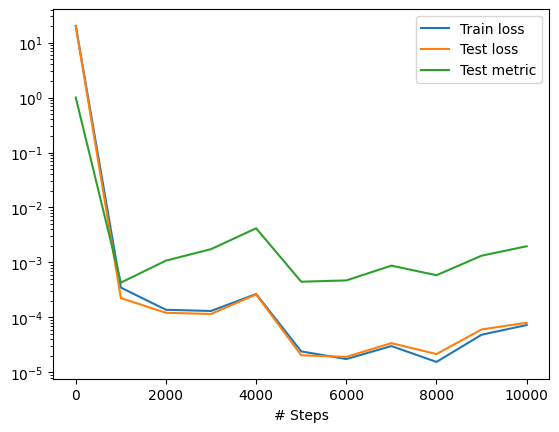

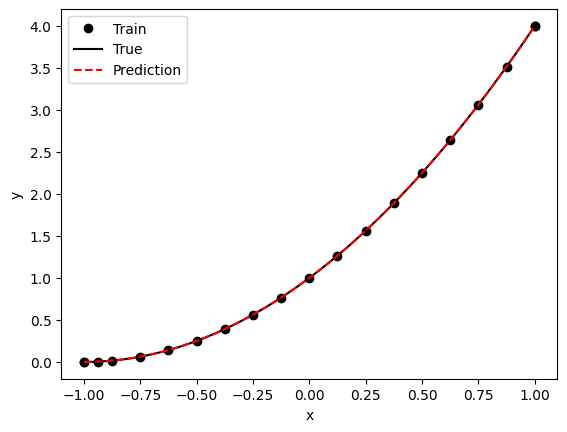

In [ ]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)